## Sequence Interpolation using block cluster

This notebook focuses on distance sequence and enumeration distance sequence. Fixed and Dwelling seqeunces are generated using the property of the census data. Thus, they are not missing from all records. Distance and Enumeration Distance are shown to be important features in the model phase.

**Criterion**: interpolate dwellings with missing sequence if they are in between 2 dwellings of the same **block cluster**. **The analysis is only on ward 10**

In [45]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation, CensusData, dataprocessing, sequences
from interpolation import CensusData, CentroidInterpolator
from interpolation import disambiguation_analysis as da

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
# from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "CD_BLOCK_NUM"
cd_ward_col = "CD_WARD_NUM"
cd_block_col = "CD_BLOCK_NUM"
dwelling_num_col = "CENSUS_DWELLING_NUM"
cd_address = "CD_H_ADDRESS"
pagenum = "CENSUS_PAGENUM"
x_col = "CD_X"
y_col = "CD_Y"

In [47]:
census_enumerators = pd.read_csv('../../data/1850_census_enumerators_120820.csv')
census_enumerators = census_enumerators.loc[census_enumerators[ward_col] == 10]

## Generate sequences

In [48]:
census_enum_seq = CensusData(census_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                 fixed = True, distance = True, d=0.1)

d:  0.1


## Apply clustering

In [49]:
cd_1850 = pd.read_csv("../../data/cd_1850_mn_20200918.csv") #For calculating centroids

#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby('CD_WARD_NUM')}

In [50]:
census_enum_seq.df.columns

Index(['CD_BLOCK_NUM', 'CD_H_ADDRESS', 'CD_X', 'CD_Y', 'CENSUS_AGE',
       'CENSUS_CITY', 'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ',
       'CENSUS_DWELLING_SIZE', 'CENSUS_FIRST_NAME', 'CENSUS_GENDER',
       'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_IMPREL', 'CENSUS_INDEX',
       'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE', 'CENSUS_LAST_NAME',
       'CENSUS_LINE', 'CENSUS_MARST', 'CENSUS_OCCUPATION', 'CENSUS_PAGENUM',
       'CENSUS_RACE', 'CENSUS_REEL', 'CENSUS_SEQ_NUM', 'CENSUS_SERIAL',
       'CENSUS_WARD_NUM', 'dwelling_id', 'spatial_weight',
       'spatial_weight_sum', 'page_sequence_id', 'PLACE',
       'CENSUS_ENUMERATOR_NUM', 'CENSUS_ENUMERATOR_DATE', 'ANCESTRY_REF',
       'CENSUS_REEL_HOUSEHOLD', 'sequence_id', 'num_between',
       'sequence_order_enum', 'dist', 'sequence_len', 'fixed_seq',
       'dwelling_seq_id', 'enum_dist_id', 'enum_dist_order', 'enum_dist',
       'enum_sequence_len'],
      dtype='object')

In [51]:
all_cols = ["CENSUS_SERIAL", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_GENDER", "CENSUS_RACE", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_FIRST_NAME", "CENSUS_LAST_NAME", "CENSUS_OCCUPATION", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols)])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

n is 5 and it's the 10th iteration


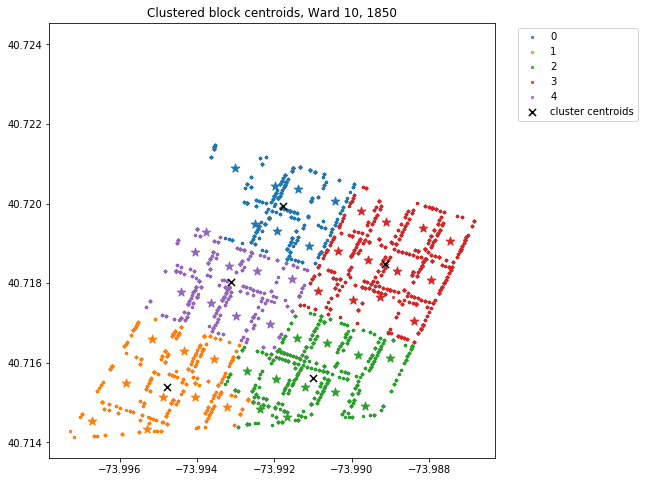

In [52]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols,
                                             KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [53]:
ward = 10
to_cluster = np.array(list(block_centroids[ward].values()))
clusters = model.predict(to_cluster)
block_num_to_cluster = {block_num: cluster for block_num, cluster in zip(block_centroids[ward].keys(), clusters)}

In [54]:
census_enum_seq.df['cluster'] = [block_num_to_cluster[i] if i in block_num_to_cluster.keys() else np.nan for i in census_enum_seq.df[block_col]]

## See how block clusters flow in the census data

Keep only dwellings with known block clusters.

In [55]:
dwelling_cluster_df = census_enum_seq.df.copy()
dwelling_cluster_df = dwelling_cluster_df.dropna(subset=['cluster'])

Text(0, 0.5, 'block cluster')

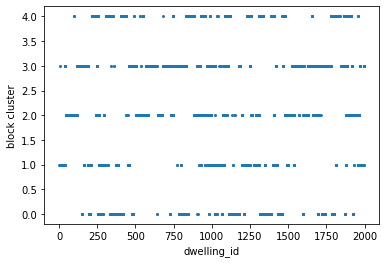

In [56]:
fig, ax = plt.subplots(1,1)
ax.scatter(dwelling_cluster_df.dwelling_id, dwelling_cluster_df.cluster, s=2)
ax.set_xlabel('dwelling_id')
ax.set_ylabel('block cluster')

There are some intervals where close dwellings are in the same block cluster. This means that we should be able to recover sequences within a block cluster interval if applicable. 

In [57]:
dist_seq_col = 'sequence_id'
dist_enum_col = 'enum_dist_id'

## Fill in sequences by looking at sequences and block cluster

### Distance sequence

Goal: Fill in **Distance sequence**  
Restriction: **Distance sequence** and **block cluster**


In [29]:
census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
dwellings_sequence = census_all_dwellings.dropna(subset=[dist_seq_col])

## 1. Get dwellings that are followed by no-sequence dwellings whose sequence can be interpolated
## dwellings_sequence => dwellings with current_seq_col not missing
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = dist_seq_col)
# dwelling_sequence_sames = dwellings_sequence.groupby(ward_col).agg(interpolation.same_next, block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                        dist_seq_col+'_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

## only check on sequence col
all_dwellings_2_dist = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = dist_seq_col,
                                                       check_column = ['cluster', dist_seq_col], ward_col = ward_col, 
                                                              dwelling_col = dwelling_col)
## remove the other sequence col. To be filled later.
all_dwellings_2_dist.drop(columns=[dist_enum_col], inplace=True)


In [30]:
all_dwellings_2_dist[[dwelling_col, 'cluster', 'sequence_id']].iloc[30:60]


,dwelling_id,cluster,sequence_id
30,31,0.0,38.0
31,32,0.0,38.0
32,33,NaN,38.0
33,34,NaN,38.0
34,35,NaN,38.0
35,36,NaN,38.0
36,37,NaN,38.0
37,38,NaN,38.0
38,39,0.0,38.0
39,40,1.0,39.0


### Enumeration Distance sequence

Goal: Fill in **Enumeration Distance sequence**  
Restriction: **Distance sequence** and **block cluster**


In [59]:
census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
dwellings_sequence = census_all_dwellings.dropna(subset=[dist_enum_col])

## 1. Get dwellings that are followed by no-sequence dwellings whose sequence can be interpolated
## dwellings_sequence => dwellings with current_seq_col not missing
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = dist_enum_col)
# dwelling_sequence_sames = dwellings_sequence.groupby(ward_col).agg(interpolation.same_next, block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                        dist_enum_col+'_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

## only check on sequence col
all_dwellings_2_enum = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = dist_enum_col,
                                                       check_column = ['cluster', dist_enum_col], ward_col = ward_col,
                                                              dwelling_col = dwelling_col)
## remove the other sequence col. To be filled later.
all_dwellings_2_enum = all_dwellings_2_enum[[dwelling_col, dist_enum_col]]

In [65]:
census_all_dwellings[['dwelling_id', dist_seq_col, 'cluster']].head(10)

,dwelling_id,sequence_id,cluster
0,1,NaN,NaN
1,2,1.0,1.0
2,3,2.0,3.0
3,4,11.0,1.0
4,5,11.0,1.0
5,6,NaN,NaN
6,7,NaN,NaN
7,8,11.0,1.0
8,9,NaN,NaN
9,10,NaN,NaN


In [67]:
all_dwellings_2[['dwelling_id', dist_seq_col, 'cluster']].head(10)

,dwelling_id,sequence_id,cluster
0,1,NaN,NaN
1,2,1.0,1.0
2,3,2.0,3.0
3,4,11.0,1.0
4,5,11.0,1.0
5,6,11.0,NaN
6,7,11.0,NaN
7,8,11.0,1.0
8,9,11.0,NaN
9,10,11.0,NaN


In [64]:
np.where(census_all_dwellings['sequence_id'].isnull())

(array([   0,    5,    6,    8,    9,   10,   12,   13,   15,   17,   18,
          22,   23,   24,   25,   26,   27,   28,   32,   33,   34,   35,
          36,   37,   40,   44,   45,   46,   47,   50,   53,   54,   55,
          58,   59,   60,   61,   62,   67,   68,   70,   71,   74,   75,
          76,   77,   78,   79,   80,   81,   82,   83,   84,   86,   87,
          88,   89,   90,   91,   94,   95,   97,   98,  100,  104,  106,
         107,  118,  121,  125,  131,  133,  142,  145,  154,  163,  165,
         167,  168,  169,  174,  178,  179,  181,  182,  183,  184,  187,
         189,  191,  193,  194,  195,  198,  200,  201,  204,  208,  210,
         211,  215,  217,  218,  220,  224,  227,  228,  231,  232,  236,
         237,  238,  241,  242,  245,  246,  247,  248,  249,  250,  251,
         253,  255,  259,  262,  263,  265,  266,  267,  268,  269,  270,
         271,  275,  277,  278,  279,  288,  289,  290,  293,  296,  297,
         303,  307,  311,  313,  314, 

### merge interpolated sequence columns into one df

In [66]:
all_dwellings_2 = all_dwellings_2_dist.copy()
all_dwellings_2[dist_enum_col] = all_dwellings_2_enum[dist_enum_col]
print(all_dwellings_2.shape)
print(all_dwellings_2_dist.shape)
print(all_dwellings_2_enum.shape)

(1995, 51)
(1995, 50)
(1995, 2)


## Result

## Proportion increased by wards

**The proportion of dwellings without addresses that have been assigned interpolated sequences to the total number of dwellings.**

In [68]:
total_num_dwellings = census_all_dwellings.groupby(ward_col)[dwelling_col].agg('nunique')
known_dist_num_dwellings = census_all_dwellings.loc[~census_all_dwellings[dist_seq_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')
known_distenum_num_dwellings = census_all_dwellings.loc[~census_all_dwellings[dist_enum_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')

In [69]:
def get_increase_prop(filled_df, filled_col, known_dwelling_by_ward, total_dwelling_by_ward):
    assigned = filled_df.loc[~filled_df[filled_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')
    additional_assigned = assigned - known_dwelling_by_ward
    return additional_assigned/total_dwelling_by_ward

In [70]:
increase_prop_dist_2 = get_increase_prop(all_dwellings_2, 'sequence_id', known_dist_num_dwellings, total_num_dwellings)
increase_prop_distenum_2 = get_increase_prop(all_dwellings_2, 'enum_dist_id', known_distenum_num_dwellings, total_num_dwellings)


In [71]:
increase_prop_dist_2

CENSUS_WARD_NUM
10    0.286216
Name: dwelling_id, dtype: float64

In [72]:
increase_prop_distenum_2

CENSUS_WARD_NUM
10    0.258647
Name: dwelling_id, dtype: float64

When restricting on block clusters rather than block numbers:
* Distance sequence interpolation: the proportion of additional assignment increase from ~0.2 to 0.29 when using block clusters 
* Distance Enumeration interpolation: from ~0.15 to 0.25

**The proportion of dwellings without sequences after the interpolation to the total number of dwellings (with and without addresses).**

In [76]:
print('%dwelling missing distance sequence: ', 
      all_dwellings_2.loc[all_dwellings_2['sequence_id'].isnull()].shape[0]\
      /total_num_dwellings)
print('%dwelling missing enumeration distance sequence: ', 
      all_dwellings_2.loc[all_dwellings_2[dist_enum_col].isnull()].shape[0]\
      /total_num_dwellings) 

%dwelling missing distance sequence:  CENSUS_WARD_NUM
10    0.162907
Name: dwelling_id, dtype: float64
%dwelling missing enumeration distance sequence:  CENSUS_WARD_NUM
10    0.196491
Name: dwelling_id, dtype: float64
